In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

In [136]:

def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create separate lists for intra-time slice and inter-time slice edges
    intra_time_slice_edges = []
    inter_time_slice_edges = []

    for edge in edges:
        if abs(int(edge[0][-1]) - int(edge[1][-1])) == 0:
            intra_time_slice_edges.append(edge)
        else:
            inter_time_slice_edges.append(edge)

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        if "FP" in node:
            color_map.append("gray")
        elif "P" == node[0]:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))

    # Draw edges first to ensure arrowheads are not covered
    nx.draw_networkx_edges(
        G, pos, edgelist=intra_time_slice_edges, arrows=True,
        edge_color='black', style='solid', arrowsize=15, arrowstyle='-|>',
        min_source_margin=10, min_target_margin=15  # Increase margins to make arrows shorter
    )

    nx.draw_networkx_edges(
        G, pos, edgelist=inter_time_slice_edges, arrows=True,
        edge_color='black', style=(0, (5, 10)), arrowsize=15, arrowstyle='-|>',
        min_source_margin=10, min_target_margin=15  # Increase margins to make arrows shorter
    )

    # Draw nodes after edges
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=color_map)

    nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

    plt.title("Bayesian Network Graph")
    plt.show()


In [137]:
# Define positions manually for x and y positions
pos = {}

for i in range(6):
    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1 - 1, 0)          # Final position x
        pos[f'P_FP_y{i}'] = (i * 3 - 1, 0)              # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1 - 1, -1)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1 - 1, -1)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3 - 1, -1)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 3)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 3)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 2)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 2)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 2)              # Initial position y
    else:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1 - 1, -1)         # Final position x
        pos[f'P_FP_y{i}'] = (i * 3 - 1, -1)             # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1 - 1, -2)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1 - 1, -2)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3 - 1, -2)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 4)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 4)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 3)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 3)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 3)              # Initial position y


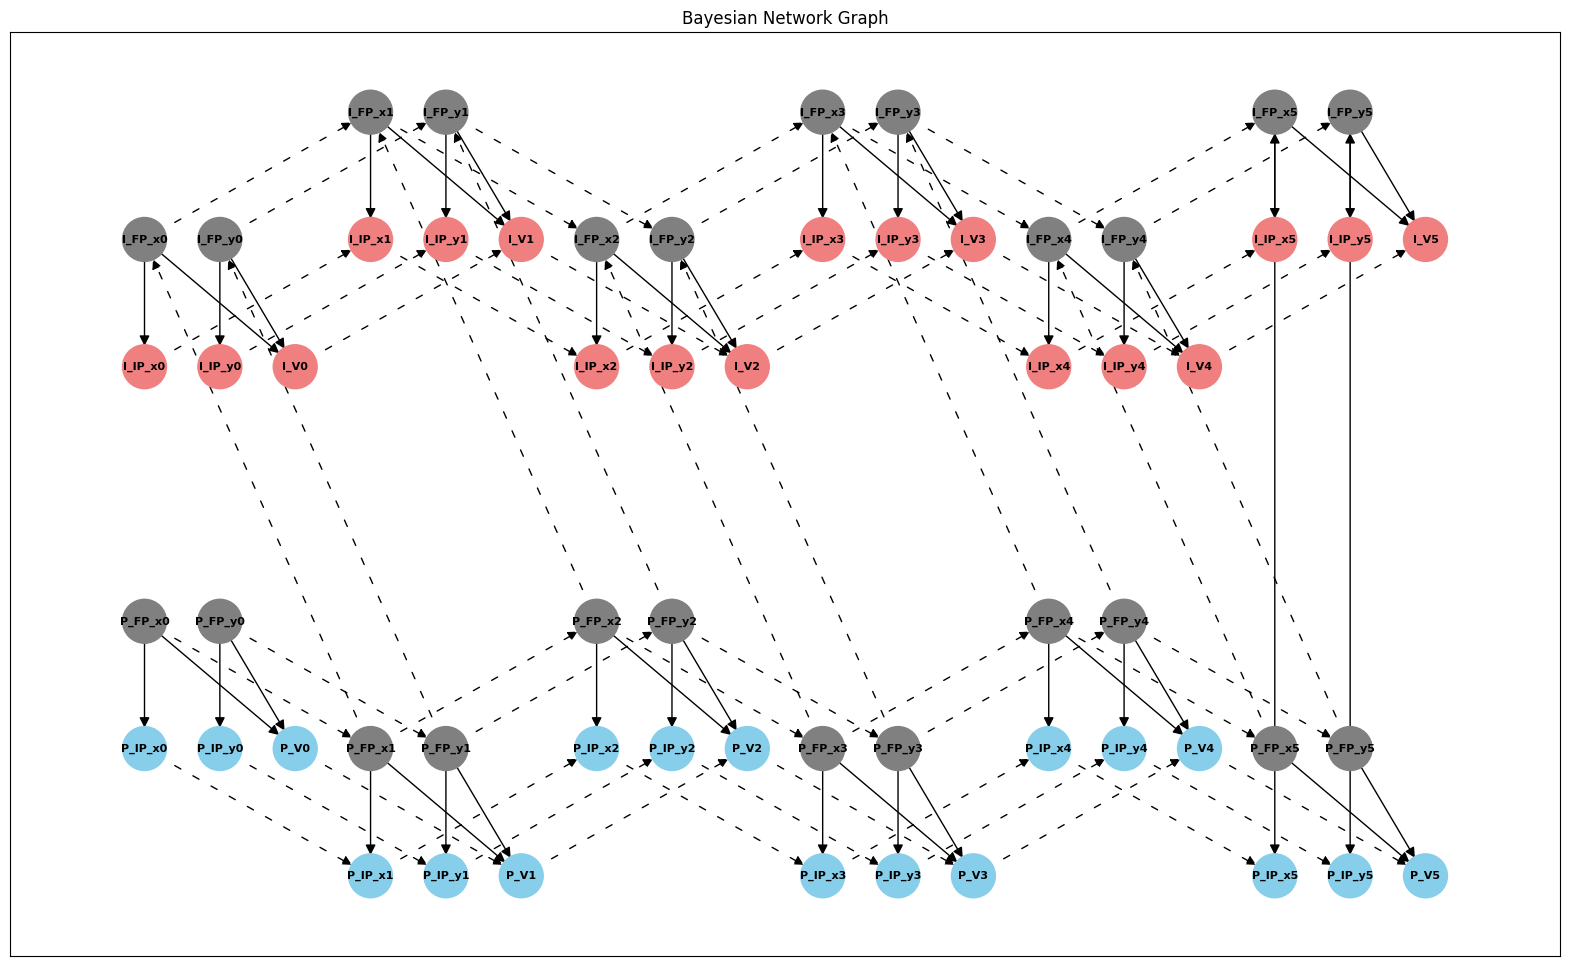

In [138]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    # Add nodes for final position (FP), velocity (V), and initial position (IP)
    GT.add_nodes_from([
        f'P_FP_x{i}', f'P_FP_y{i}', f'P_V{i}', f'P_IP_x{i}', f'P_IP_y{i}',  # Projectile nodes
        f'I_FP_x{i}', f'I_FP_y{i}', f'I_V{i}', f'I_IP_x{i}', f'I_IP_y{i}'   # Interceptor nodes
    ])
    
    # Add edges within each time slice for both x and y positions
    GT.add_edges_from([
        (f'P_FP_x{i}' , f'P_IP_x{i}'),  # Initial position (x) influences final position (x)
        (f'P_FP_x{i}' , f'P_V{i}'),     # Velocity influences final position (x)
        (f'P_FP_y{i}' , f'P_IP_y{i}'),  # Initial position (y) influences final position (y)
        (f'P_FP_y{i}', f'P_V{i}'),     # Velocity influences final position (y)
        
        (f'I_FP_x{i}' , f'I_IP_x{i}'),  # Interceptor: Initial position (x) influences final position (x)
        (f'I_FP_x{i}' , f'I_V{i}'),     # Velocity influences final position (x)
        (f'I_FP_y{i}' , f'I_IP_y{i}'),  # Initial position (y) influences final position (y)
        (f'I_FP_y{i}' , f'I_V{i}')      # Velocity influences final position (y)
    ])

    if i < 5:
        # Connect corresponding nodes between time slices for projectile and interceptor
        GT.add_edges_from([
            # Projectile time slice connections for x and y positions
            (f'P_FP_x{i}', f'P_FP_x{i + 1}'),
            (f'P_IP_x{i}', f'P_IP_x{i + 1}'),
            (f'P_FP_y{i}', f'P_FP_y{i + 1}'),
            (f'P_IP_y{i}', f'P_IP_y{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),

            # Interceptor time slice connections for x and y positions
            (f'I_FP_x{i}', f'I_FP_x{i + 1}'),
            (f'I_IP_x{i}', f'I_IP_x{i + 1}'),
            (f'I_FP_y{i}', f'I_FP_y{i + 1}'),
            (f'I_IP_y{i}', f'I_IP_y{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}')
        ])
        
        # Edge between projectile and interceptor across time slices
        GT.add_edges_from([
            (f'P_FP_x{i + 1}', f'I_FP_x{i}'),
            (f'P_FP_y{i + 1}', f'I_FP_y{i}')
        ])

# Final edges to ensure convergence at the last time slice
GT.add_edges_from([
    (f'P_FP_x{5}', f'I_FP_x{5}'),
    (f'P_FP_y{5}', f'I_FP_y{5}')
])


visualise(GT, pos)




In [139]:
for i in range(6):
    if i == 0:
        # Projectile CPDs for x and y positions
        cpd_P_FP_x = LinearGaussianCPD(
            f'P_FP_x{0}', 
            [0.0], 
            2.0, 
            []  # x-component velocity and initial x position
        )

        cpd_P_FP_y = LinearGaussianCPD(
            f'P_FP_y{0}', 
            [0.0], 
            2.0, 
            []  # y-component velocity and initial y position
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{0}', 
            [20.0, 1, 1],  
            10.0, 
            [f'P_FP_x{0}' , f'P_FP_y{0}']  # No parents for velocity in first time slice
        )

        cpd_P_IP_x = LinearGaussianCPD(
            f'P_IP_x{0}',
            [10000.0, 1],  
            30000,
            [f'P_FP_x{0}']  # No parents for initial x position in first time slice
        )

        cpd_P_IP_y = LinearGaussianCPD(
            f'P_IP_y{0}',
            [0.0, 1],  
            0.0,
            [f'P_FP_y{0}']  # No parents for initial y position in first time slice
        )

    else:
        # Projectile CPDs for x and y positions
        cpd_P_FP_x = LinearGaussianCPD(
            f'P_FP_x{i}', 
            [0.0,  0.1],  
            2.0, 
            [f'P_FP_x{i - 1}']  # x velocity and previous positions
        )

        cpd_P_FP_y = LinearGaussianCPD(
            f'P_FP_y{i}', 
            [0.0, 0.1],  
            2.0, 
            [f'P_FP_y{i - 1}']  # y velocity and previous positions
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0, 1, 1, 1],  
            5.0, 
            [f'P_V{i - 1}', f'P_FP_x{i}', f'P_FP_y{i}']  # Velocity depends on the previous velocity
        )

        cpd_P_IP_x = LinearGaussianCPD(
            f'P_IP_x{i}',
            [0.0, 1,1],  
            3,
            [ f'P_FP_x{i}', f'P_IP_x{i - 1}']  # Initial x position depends on the previous final x position
        )

        cpd_P_IP_y = LinearGaussianCPD(
            f'P_IP_y{i}',
            [0.0, 1,1],  
            300,
            [ f'P_FP_y{i}', f'P_IP_y{i - 1}']  # Initial y position depends on the previous final y position
        )

    GT.add_cpds(cpd_P_FP_x, cpd_P_FP_y, cpd_P_V, cpd_P_IP_x, cpd_P_IP_y)


# Interceptor CPDs
for i in range(6):
    if i == 0:
        # Interceptor CPDs for x and y positions
        cpd_I_FP_x = LinearGaussianCPD(
            f'I_FP_x{0}', 
            [0.0, 0.1],  
            3.0, 
            [f'P_FP_x{1}']  # x-component of final position depends on next projectile position, initial x, and velocity
        )

        cpd_I_FP_y = LinearGaussianCPD(
            f'I_FP_y{0}', 
            [0.0, 0.1],  
            3.0, 
            [f'P_FP_y{1}']  # y-component of final position depends on next projectile position, initial y, and velocity
        )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{0}', 
            [20.0, 1, 1],  
            10.0, 
            [f'I_FP_x{0}', f'I_FP_y{0}']  # No parents for velocity in first time slice
        )

        cpd_I_IP_x = LinearGaussianCPD(
            f'I_IP_x{0}',
            [0.0, 1],  
            0.0,
            [f'I_FP_x{0}']  # No parents for initial x position in first time slice
        )

        cpd_I_IP_y = LinearGaussianCPD(
            f'I_IP_y{0}',
            [0.0, 1],  
            0.0,
            [f'I_FP_y{0}']  # No parents for initial y position in first time slice
        )

    else:
        # Interceptor CPDs for x and y positions
        if i < 4: 
            cpd_I_FP_x = LinearGaussianCPD(
            f'I_FP_x{i}', 
            [0.0, 0.5, 0.1],  
            3.0, 
            [f'P_FP_x{i+1}', f'I_FP_x{i - 1}']  # x-component of final position depends on next projectile position, initial x, and velocity
            )

            cpd_I_FP_y = LinearGaussianCPD(
                f'I_FP_y{i}', 
                [0.0, 0.5, 0.1],  
                3.0, 
                [f'P_FP_y{i+1}', f'I_FP_y{i - 1}']  # y-component of final position depends on next projectile position, initial y, and velocity
            )
        elif i < 5:
            cpd_I_FP_x = LinearGaussianCPD(
                f'I_FP_x{i}', 
                [0.0, 0.6, 0.1], 
                3.0, 
                [f'P_FP_x{i+1}', f'I_FP_x{i - 1}']  # x-component depends on projectile and previous positions
            )

            cpd_I_FP_y = LinearGaussianCPD(
                f'I_FP_y{i}', 
                [0.0, 0.6, 0.1], 
                3.0, 
                [f'P_FP_y{i+1}', f'I_FP_y{i - 1}']  # y-component depends on projectile and previous positions
            )
        else:
            cpd_I_FP_x = LinearGaussianCPD(
                f'I_FP_x{i}', 
                [0.0, 0.0, 1],  
                3.0, 
                [f'I_FP_x{i - 1}', f'P_FP_x{i}']  # x-component for final time slice
            )

            cpd_I_FP_y = LinearGaussianCPD(
                f'I_FP_y{i}', 
                [0.0, 0.0, 1],  
                3.0, 
                [f'I_FP_y{i - 1}', f'P_FP_y{i}']  # y-component for final time slice
            )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [20.0, 1, 1, 1],  
            5.0, 
            [f'I_V{i - 1}', f'I_FP_x{i}', f'I_FP_y{i}']  # Velocity depends on previous velocity
        )

        cpd_I_IP_x = LinearGaussianCPD(
            f'I_IP_x{i}',
            [0.0, 1, 1], 
            30,
            [ f'I_FP_x{i}', f'I_IP_x{i - 1}']  # Initial x position depends on previous final x position
        )

        cpd_I_IP_y = LinearGaussianCPD(
            f'I_IP_y{i}',
            [0.0, 1, 1], 
            30,
            [ f'I_FP_y{i}', f'I_IP_y{i - 1}']  # Initial y position depends on previous final y position
        )

   
    GT.add_cpds(cpd_I_FP_x, cpd_I_FP_y, cpd_I_V, cpd_I_IP_x, cpd_I_IP_y)


In [140]:

if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


The model is valid!


In [141]:
import numpy as np
import pandas as pd
from pgmpy.models import LinearGaussianBayesianNetwork

def get_topological_order(model):
    """
    Function to return nodes of the Bayesian Network in topological order.
    """
    nodes = list(model.nodes())
    order = []
    visited = set()
    
    def visit(node):
        if node not in visited:
            visited.add(node)
            for parent in model.get_parents(node):
                visit(parent)
            order.append(node)
    
    for node in nodes:
        visit(node)
    
    return order

def sample_from_lgbn(model, n_samples=1000):
    """Perform forward sampling from a Linear Gaussian Bayesian Network."""
   
    topological_order = get_topological_order(model)
    print(topological_order)
    # Initialize an empty DataFrame for storing samples
    samples_df = pd.DataFrame(index=range(n_samples), columns=topological_order)

    for node in topological_order:
        cpd = model.get_cpds(node)

        # Mean and variance of the CPD
        mean = np.array(cpd.mean).flatten()
        variance = np.array(cpd.variance).flatten()

        if len(mean) != 1 and len(variance) != 1:
            raise ValueError(f"Mean and variance for node {node} must be scalar or match dimensions.")

        if not cpd.evidence:
            # Node has no parents, sample directly
            samples_df[node] = np.random.normal(loc=mean[0], scale=np.sqrt(variance), size=n_samples)
        else:
            # Ensure parent columns are converted to float
            parent_values = samples_df[cpd.evidence].astype(float).values
            # Reshape parent_values to ensure it matches dimensions
            if parent_values.shape[1] != len(mean[1:]):
                print(cpd.variables)
                raise ValueError(f"Number of parent columns ({parent_values.shape[1]}) does not match the number of coefficients ({len(mean[1:])}).")
            
            # Calculate the mean based on the parent's sampled values
            parent_mean = np.dot(parent_values, mean[1:]) + mean[0]
            # Sample from the Gaussian distribution
            samples_df[node] = np.random.normal(loc=parent_mean, scale=np.sqrt(variance), size=n_samples)

    return samples_df


n_samples = 10000
samples_df = sample_from_lgbn(GT, n_samples=n_samples)

samples_df.to_csv("trajectory_data.csv", index=False)
print(f"Generated {n_samples} samples and saved to trajectory_data.csv")




['P_FP_x0', 'P_FP_y0', 'P_V0', 'P_IP_x0', 'P_IP_y0', 'P_FP_x1', 'I_FP_x0', 'P_FP_y1', 'I_FP_y0', 'I_V0', 'I_IP_x0', 'I_IP_y0', 'P_IP_x1', 'P_IP_y1', 'P_V1', 'P_FP_x2', 'I_FP_x1', 'I_IP_x1', 'P_FP_y2', 'I_FP_y1', 'I_IP_y1', 'I_V1', 'P_IP_x2', 'P_IP_y2', 'P_V2', 'P_FP_x3', 'I_FP_x2', 'I_IP_x2', 'P_FP_y3', 'I_FP_y2', 'I_IP_y2', 'I_V2', 'P_IP_x3', 'P_IP_y3', 'P_V3', 'P_FP_x4', 'I_FP_x3', 'I_IP_x3', 'P_FP_y4', 'I_FP_y3', 'I_IP_y3', 'I_V3', 'P_IP_x4', 'P_IP_y4', 'P_V4', 'P_FP_x5', 'I_FP_x4', 'I_IP_x4', 'P_FP_y5', 'I_FP_y4', 'I_IP_y4', 'I_V4', 'P_IP_x5', 'P_IP_y5', 'P_V5', 'I_FP_x5', 'I_IP_x5', 'I_FP_y5', 'I_IP_y5', 'I_V5']
Generated 10000 samples and saved to trajectory_data.csv


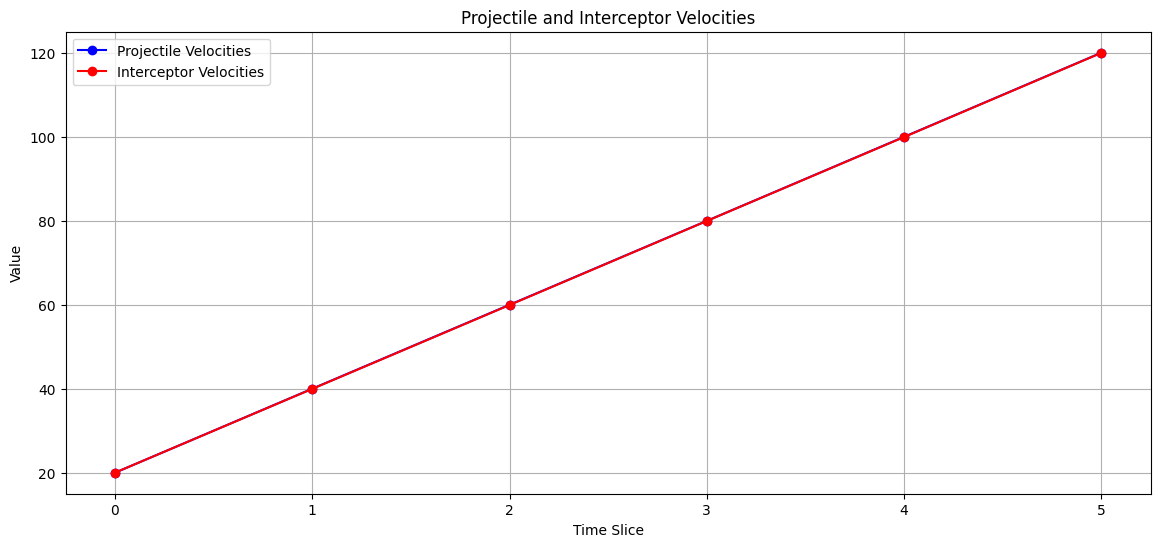

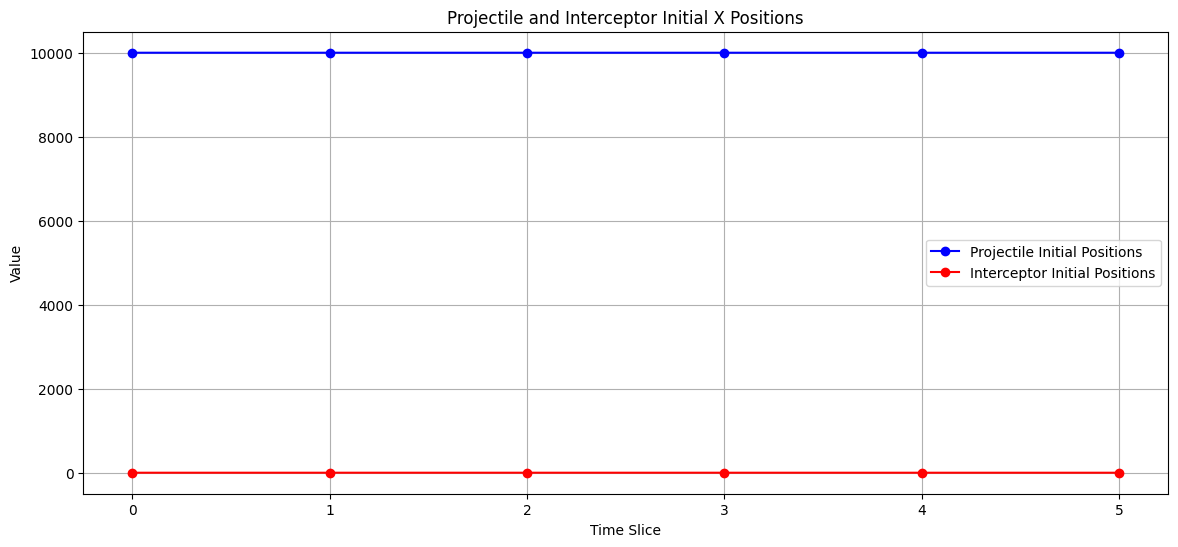

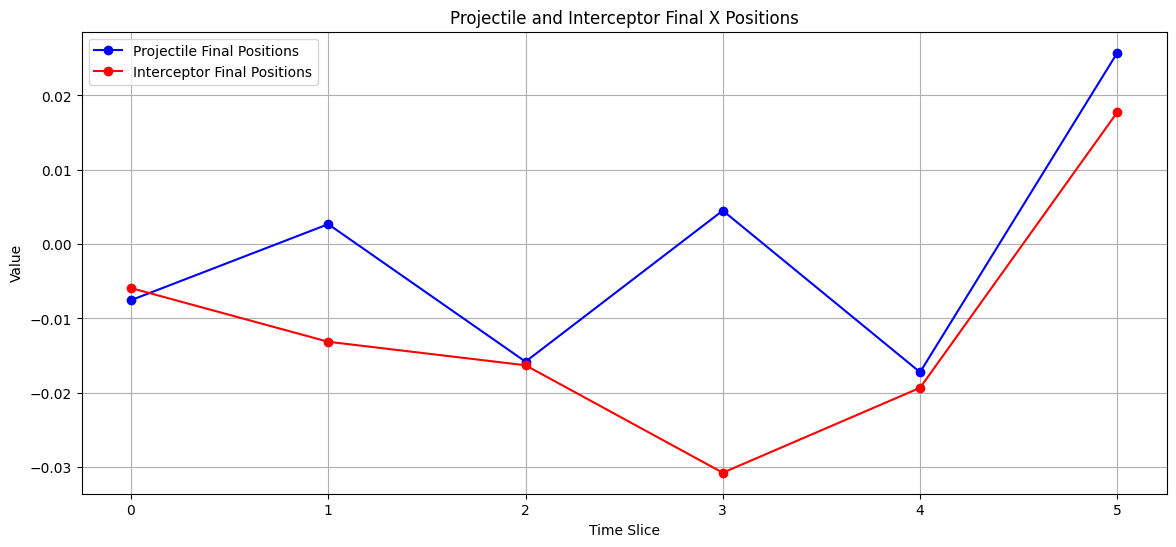

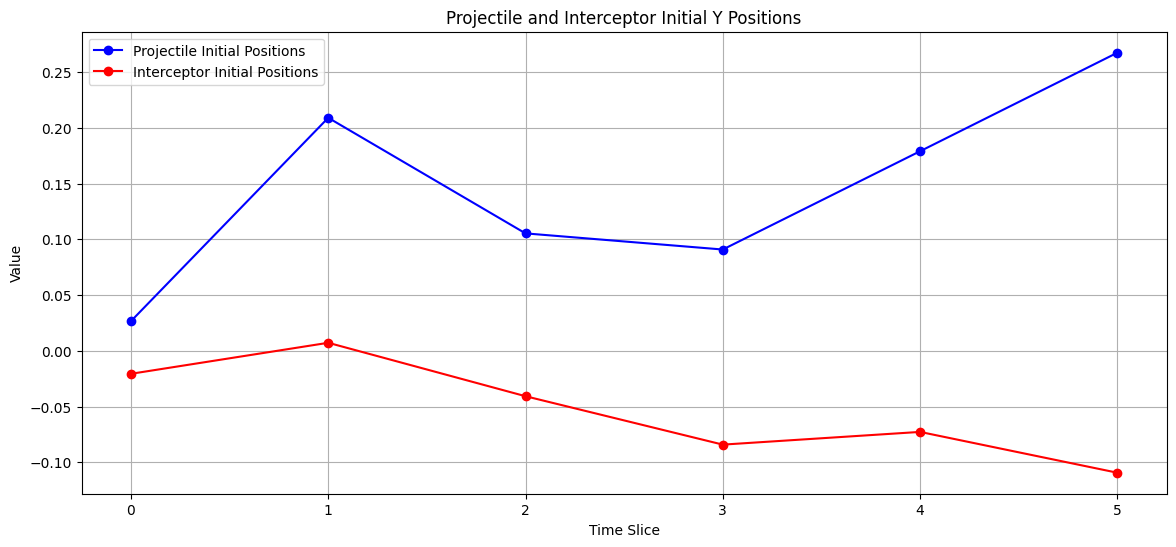

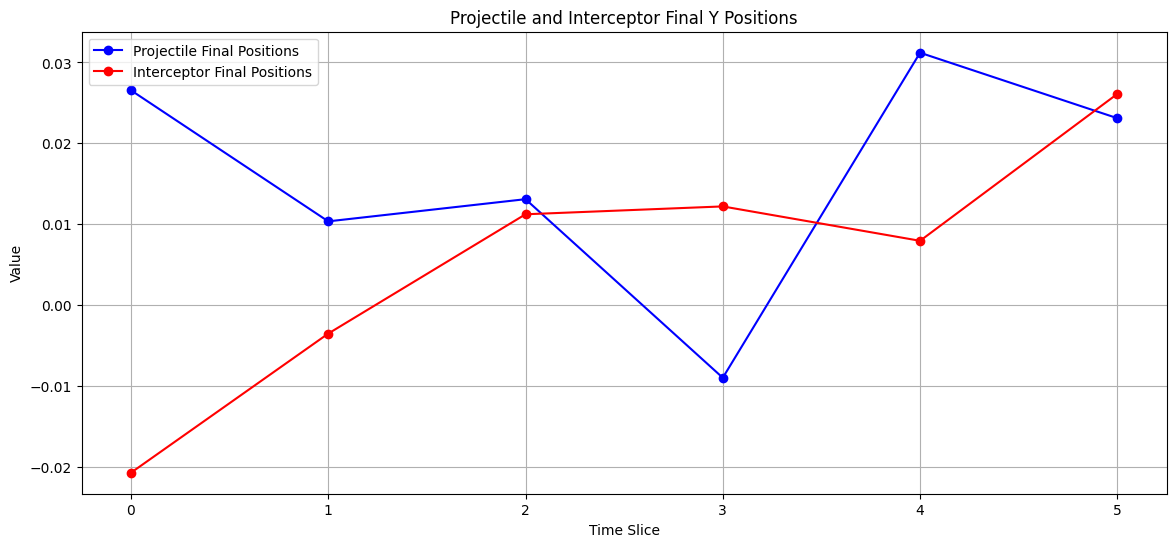

In [142]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = 'trajectory_data.csv' 
data = pd.read_csv(file_path)

# Convert all columns to numeric, forcing non-numeric values to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Define time slices
time_slices = [0, 1, 2, 3, 4, 5]

# Define columns to plot for velocities and angles
projectile_velocities = ['P_V0', 'P_V1', 'P_V2', 'P_V3', 'P_V4', 'P_V5']
interceptor_velocities = ['I_V0', 'I_V1', 'I_V2', 'I_V3', 'I_V4', 'I_V5']

projectile_ips_x = [f'P_IP_x{i}' for i in range(6)]
projectile_fps_x = [f'P_FP_x{i}' for i in range(6)]
interceptor_ips_x = [f'I_IP_x{i}' for i in range(6)]
interceptor_fps_x = [f'I_FP_x{i}' for i in range(6)]

projectile_ips_y = [f'P_IP_y{i}' for i in range(6)]
projectile_fps_y = [f'P_FP_y{i}' for i in range(6)]
interceptor_ips_y = [f'I_IP_y{i}' for i in range(6)]
interceptor_fps_y = [f'I_FP_y{i}' for i in range(6)]


# Function to plot velocities or angles
def plot_values(data, projectile_columns, interceptor_columns, title, label):
    plt.figure(figsize=(14, 6))
    
    # Plot projectile velocities
    plt.plot(time_slices, data[projectile_columns].mean(axis=0), marker='o', label='Projectile ' + label, color='blue')
    
    # Plot interceptor velocities
    plt.plot(time_slices, data[interceptor_columns].mean(axis=0), marker='o', label='Interceptor ' + label, color='red')
    
    plt.xlabel('Time Slice')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plot velocities for projectile and interceptor
plot_values(data, projectile_velocities, interceptor_velocities, 'Projectile and Interceptor Velocities', "Velocities")
plt.show()

# Plot velocities for projectile and interceptor
plot_values(data, projectile_ips_x, interceptor_ips_x, 'Projectile and Interceptor Initial X Positions', "Initial Positions")
plt.show()

# Plot angles for projectile and interceptor
plot_values(data, projectile_fps_x, interceptor_fps_x, 'Projectile and Interceptor Final X Positions', "Final Positions")
plt.show()

# Plot velocities for projectile and interceptor
plot_values(data, projectile_ips_y, interceptor_ips_y, 'Projectile and Interceptor Initial Y Positions', "Initial Positions")
plt.show()

# Plot angles for projectile and interceptor
plot_values(data, projectile_fps_y, interceptor_fps_y, 'Projectile and Interceptor Final Y Positions', "Final Positions")
plt.show()





C:\Users\suvar\AppData\Local\Temp\ipykernel_29496\3243247530.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x_values[i], y_values[i], f'{time_slice}', fontsize=12)
C:\Users\suvar\AppData\Local\Temp\ipykernel_29496\3243247530.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x_values[i], y_values[i], f'{time_slice}', fontsize=12)


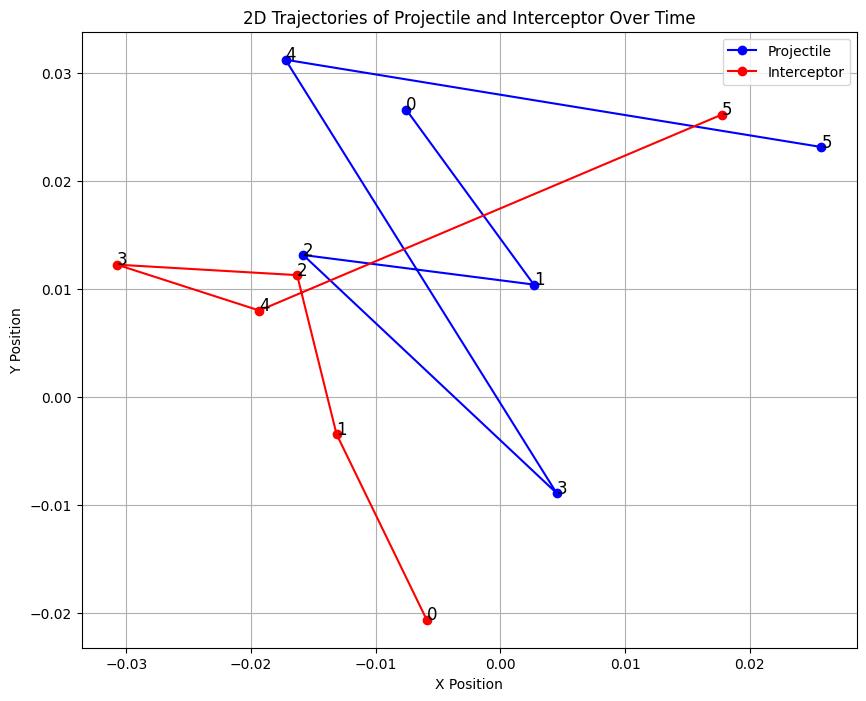

In [143]:
# Function to plot 2D trajectories over time with connected points
def plot_2d_trajectories(data, x_columns, y_columns, label, color):
    # Extract the mean values for X and Y positions over time slices
    x_values = data[x_columns].mean(axis=0)
    y_values = data[y_columns].mean(axis=0)
    
    # Plot the trajectory by connecting the points
    plt.plot(x_values, y_values, marker='o', color=color, label=label)
    
    # Annotate each point with the corresponding time slice
    for i, time_slice in enumerate(time_slices):
        plt.text(x_values[i], y_values[i], f'{time_slice}', fontsize=12)

# Plot the X and Y 2D trajectory for both projectile and interceptor
plt.figure(figsize=(10, 8))
plt.title('2D Trajectories of Projectile and Interceptor Over Time')
plt.xlabel('X Position')
plt.ylabel('Y Position')

# Plot projectile trajectory with connected points
plot_2d_trajectories(data, projectile_fps_x, projectile_fps_y, "Projectile", "blue")

# Plot interceptor trajectory with connected points
plot_2d_trajectories(data, interceptor_fps_x, interceptor_fps_y, "Interceptor", "red")

# # Plot projectile trajectory with connected points
# plot_2d_trajectories(data, projectile_ips_x, projectile_ips_y, "Projectile", "blue")

# # Plot interceptor trajectory with connected points
# plot_2d_trajectories(data, interceptor_ips_x, interceptor_ips_y, "Interceptor", "red")

plt.legend()
plt.grid(True)
plt.show()


